# Coverage and Quality Plots

Input: 
1. Gene counts table from FeatureCounts
2. Gene Body Coverage Files

## LOAD LIBRARIES

In [7]:
from pydeseq2.dds import DeseqDataSet
from pydeseq2.default_inference import DefaultInference
from pydeseq2.ds import DeseqStats
import re
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib as mpl
import gtfparse as gtf_parse
import seaborn as sns
import os.path
import itertools
import matplotlib.gridspec as gridspec
import copy

In [8]:
def parse_gtf(gtf_path):
    genes = []
    opener = gzip.open if gtf_path.endswith(".gz") else open
    with opener(gtf_path, "rt") as f:
        for line in f:
            if line.startswith("#") or "\tgene\t" not in line:
                continue
            parts = line.strip().split("\t")
            chrom, source, feature, start, end, score, strand, frame, attributes = parts
            gene_id = None
            gene_name = None
            gene_type = None
            for attr in attributes.split(";"):
                if "gene_id" in attr:
                    gene_id = attr.split('"')[1]
                if "gene_name" in attr:
                    gene_name = attr.split('"')[1]
                if "gene_type" in attr:
                    gene_type = attr.split('"')[1]
                if gene_id and gene_name and gene_type:
                    break
            if gene_id:
                genes.append({
                    "gene_id": gene_id,
                    "chrom": chrom,
                    "start": int(start),
                    "end": int(end),
                    "strand": strand,
                    "gene_name" : gene_name,
                    "gene_type" : gene_type
                })
    return genes

GTF_PATH = "/raid/chhewel_analysis/RNA004_Manuscript_reanalysis/BEDMETHYL_files/last_filter_round/test/gencode.v43.sorted.gtf"  # Can be gzipped (.gtf.gz)
gene_list = parse_gtf(GTF_PATH)
genes_df = pd.DataFrame.from_dict(gene_list)

# 1. TRANSCRIPTOME-WIDE GENE COUNTS

In [9]:

# Read featureCounts table from all ONT samples
counts_file="RNA002_RNA004.DORADO.0.7.2.GRCh38.featurecounts.tsv"
counts_file="/raid/chhewel_analysis/RNA004_Manuscript_reanalysis/DORADO_0_7_2_folder/RNA002_RNA004.DORADO.0.7.2.GRCh38.featurecounts.tsv"
counts = pd.read_csv(counts_file, sep = "\t", header = 0, comment='#')
counts = counts.set_index("Geneid")
counts = counts.drop(['Chr', 'Start', 'End', 'Strand', 'Length'], axis=1)
counts = counts.drop(columns=[col for col in counts.columns if '_E' in col])
counts = counts.drop(columns=[col for col in counts.columns if '_ribo' in col])
print(counts.columns)
counts.columns =['RNA002_HEK293T_A', 'RNA002_HEK293T_B', 'RNA002_blood_1',
       'RNA002_blood_IVT_1', 'RNA002_UHRR', 'RNA004_HEK293T_A',
       'RNA004_HEK293T_B', 'RNA004_blood_1', 'RNA004_blood_IVT_1', 'RNA004_UHRR_1',
       'RNA004_UHRR_2', 'RNA004_UHRR_3']

counts_file2="/raid/chhewel_analysis/RNA004_Manuscript_reanalysis/S5_analysis_5_12_24/S5_RNA004.DORADO.0.7.2.GRCh38.featurecounts.tsv"
counts2 = pd.read_csv(counts_file2, sep = "\t", header = 0, comment='#')
counts2 = counts2.set_index("Geneid")
counts2 = counts2.drop(['Chr', 'Start', 'End', 'Strand', 'Length'], axis=1)
print(counts2.columns)
counts2.columns = ["RNA004_blood_2"]

counts_file3="/raid/chhewel_analysis/RNA004_Manuscript_reanalysis/S6_IVT_analysis/S6_RNA004.DORADO.0.7.2.GRCh38.featurecounts.tsv"
counts3 = pd.read_csv(counts_file3, sep = "\t", header = 0, comment='#')
counts3 = counts3.set_index("Geneid")
counts3 = counts3.drop(['Chr', 'Start', 'End', 'Strand', 'Length'], axis=1)
print(counts3.columns)
counts3.columns = ["RNA004_blood_3", "RNA004_blood_IVT_3_R1", "RNA004_blood_IVT_3_R2"]

counts = pd.concat([counts, counts2, counts3], axis=1)


metadata = pd.DataFrame({"sample" : counts.columns})
metadata["tissue"] = metadata["sample"].str.replace("_[A|B|1|2|3].*$", "", regex=True)
metadata["chem_type"] = metadata["tissue"].str.replace("_.*$", "", regex=True)
metadata["ID"] = metadata["sample"].str.replace("RNA00[2|4]_", "", regex=True)
metadata["tissue_flat"] = metadata["tissue"].str.replace("RNA00[2|4]_", "", regex = True)



Index(['RNA002_A_basecall.0.7.2.GRCh38.bam',
       'RNA002_B_basecall.0.7.2.GRCh38.bam', 'RNA002_blood.0.7.2.GRCh38.bam',
       'RNA002_blood_IVT.0.7.2.GRCh38.bam',
       'RNA002_UHRR_basecall.0.7.2.GRCh38.bam',
       'RNA004_A_basecall.0.7.2.GRCh38.bam',
       'RNA004_B_basecall.0.7.2.GRCh38.bam', 'RNA004_blood.0.7.2.GRCh38.bam',
       'RNA004_blood_IVT.0.7.2.GRCh38.bam',
       'RNA004_UHRR_1_basecall.0.7.2.GRCh38.bam',
       'RNA004_UHRR_2_basecall.0.7.2.GRCh38.bam',
       'RNA004_UHRR_3.0.7.2.GRCh38.bam'],
      dtype='object')
Index(['RNA004_S5_DRS_basecall.0.7.2.GRCh38.bam'], dtype='object')
Index(['RNA004_S6_DRS_basecall.0.7.2.GRCh38.bam',
       'RNA004_S6_IVT_basecall.0.7.2.GRCh38.bam',
       'RNA004_S6_IVT_LI_basecall.0.7.2.GRCh38.bam'],
      dtype='object')


In [10]:
counts_tissue = counts.loc[:, ~counts.columns.str.contains('IVT')]
metadata_tissue = metadata.loc[~metadata["sample"].str.contains("IVT"), :]

# Extract genes covered by at least 10 reads in each sample type
df_covered_genes = (counts_tissue >= 10).sum(axis=0)

gene_counts_10 = pd.DataFrame(df_covered_genes)
gene_counts_10 = gene_counts_10.reset_index()
gene_counts_10.columns = ["sample_type", "# genes covered >= 10"]
gene_counts_10  = pd.merge(metadata_tissue.reset_index(), gene_counts_10, left_on='sample', right_on='sample_type', how = "left")
gene_counts_10_sub = gene_counts_10[["ID", "sample_type", "tissue_flat", "chem_type", "# genes covered >= 10"]]


In [11]:
gene_counts_10_sub.to_csv("~/NEW_RNA004_PLOTS/TABLES/PAPER_TABLES_genes_cov_10.tsv", sep = "\t", index = False)

counts_df = counts.reset_index()
counts_df_annot = pd.merge(genes_df, counts_df.rename(columns ={"Geneid" : "gene_id"}), on = "gene_id", how = "left")


In [6]:
counts_df_annot.gene_type.value_counts()

gene_type
protein_coding                        20042
lncRNA                                18874
processed_pseudogene                  10148
unprocessed_pseudogene                 2608
misc_RNA                               2212
snRNA                                  1901
miRNA                                  1879
TEC                                    1054
transcribed_unprocessed_pseudogene      959
snoRNA                                  942
transcribed_processed_pseudogene        512
rRNA_pseudogene                         497
IG_V_pseudogene                         187
transcribed_unitary_pseudogene          155
IG_V_gene                               145
TR_V_gene                               107
unitary_pseudogene                       99
TR_J_gene                                79
scaRNA                                   49
rRNA                                     47
IG_D_gene                                37
TR_V_pseudogene                          33
Mt_tRNA               

### FIGURE 3B

4
4
4
7.199999999999999
[0.33333333333333337, 0.33333333333333337, 0.33333333333333337]
['RNA002_HEK293T_A' 'RNA004_HEK293T_A' 'RNA002_HEK293T_B'
 'RNA004_HEK293T_B']
['RNA002_UHRR' 'RNA004_UHRR_1' 'RNA004_UHRR_2' 'RNA004_UHRR_3']
['RNA002_blood_1' 'RNA004_blood_1' 'RNA004_blood_2' 'RNA004_blood_3']


/tmp/ipykernel_3028610/995637611.py:53: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([t.get_text().replace("RNA002_", "").replace("RNA004_", "")
/tmp/ipykernel_3028610/995637611.py:53: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([t.get_text().replace("RNA002_", "").replace("RNA004_", "")
/tmp/ipykernel_3028610/995637611.py:53: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([t.get_text().replace("RNA002_", "").replace("RNA004_", "")


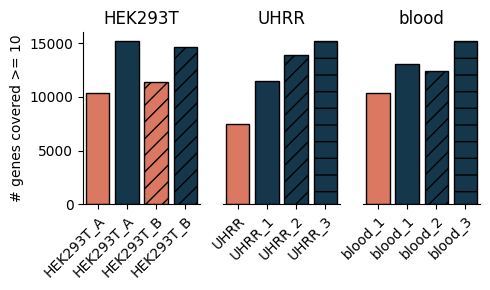

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# --- Setup ---
# Assuming `gene_counts_10_sub` is your DataFrame
tissue_groups = gene_counts_10_sub.groupby("tissue_flat")
colors_input = {"RNA002": "#ee6c4d", "RNA004": "#0b3954", "NGS": "#8b5cf6"}
hatches = [['','//', '', '//'],['', '', '//', '-'], ['', '', '//', '-'],['', '', '//', '//']]

# Bar width settings
bar_width = 0.6
spacing = 0
facet_widths = []

# Calculate subplot widths based on number of bars in each facet
facet_data = []
for tissue, df in tissue_groups:
    n_bars = df['sample_type'].nunique()
    print(n_bars)
    width = max(1, n_bars * (bar_width + spacing))
    facet_data.append((tissue, df))
    facet_widths.append(width)

# Normalize widths for matplotlib gridspec
total_width = sum(facet_widths)
print(total_width)
normalized_widths = [w / total_width for w in facet_widths]
print(normalized_widths)
# --- Create Subplots with variable widths ---
fig_height = 3
n_facets = len(facet_data)
fig, axes = plt.subplots(1, n_facets, figsize=(5, fig_height), 
                         gridspec_kw={'width_ratios': normalized_widths})

# Handle single facet case
if n_facets == 1:
    axes = [axes]

# --- Plotting each facet ---
for c, (ax, (tissue, df)) in enumerate(zip(axes, facet_data)):
    #print(df)
    print(df.sort_values("ID")["sample_type"].unique())
    order_list = df.sort_values("ID")["sample_type"].unique()
   
    sns.barplot(
        data=df, y="# genes covered >= 10", x="sample_type", hue="chem_type",
        ax=ax, palette=colors_input,order  = order_list, edgecolor="black", width=0.8
    )
    if c >= 1:
        ax.tick_params(left=False, bottom=True, labelleft=False, labelbottom=True)
    # Clean x labels
    ax.set_xticklabels([t.get_text().replace("RNA002_", "").replace("RNA004_", "") 
                        for t in ax.get_xticklabels()], rotation=45, ha = "right", rotation_mode='anchor')
    ax.grid(False)
    

    ax.set_title(tissue)
    ax.set_xlabel("")
    ax.set_ylabel("# genes covered >= 10" if c == 0 else "")

    ax.legend([],[], frameon=False) 

    # Set hatches
    for i, bar in enumerate(ax.patches):
        if c < len(hatches) and i < len(hatches[c]):
            bar.set_hatch(hatches[c][i])
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    if tissue == "Summed":
        
        ax.spines["left"].set_visible(True)
        ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
   
    if c >= 1 and tissue != "Summed":
        ax.tick_params(left=False, bottom=True, labelleft=False, labelbottom=True)

        ax.spines["left"].set_visible(False)



fig.tight_layout()
fig.subplots_adjust(wspace=0.2, hspace=0)

plt.show()


fig.savefig("/raid/awiercze_analysis/RNA004_REVISION_NAR/PAPER_FIGURE_3A_NEW2.svg", dpi = 300)
fig.savefig("/raid/awiercze_analysis/RNA004_REVISION_NAR/PAPER_FIGURE_3A_NEW2.pdf", dpi = 300)
fig.savefig("/raid/awiercze_analysis/RNA004_REVISION_NAR/PAPER_FIGURE_3A_NEW2.png", dpi = 300)


# 2. MENDELIOME-WIDE GENE COUNTS

In [13]:
### LOAD MENDELIOM GENES 
#mendeliom = pd.read_csv("mendeliom_IHDB.tsv", sep = "\t")
mendeliom = pd.read_csv("/raid/awiercze_analysis/RESEARCH/REVISION_FIGURES/mendeliom_IHDB.tsv", sep = "\t")



In [14]:

counts_ensembl =  counts_tissue
counts_ensembl.index = [i.split('.')[0] for i in counts_ensembl.index]
counts_ensembl["gene_id"] = counts_ensembl.index
counts_mendel = counts_ensembl[counts_ensembl["gene_id"].isin(mendeliom.ensembl_gene_id)]
counts_mendel = counts_mendel.drop("gene_id", axis = 1)

global_counts = counts_ensembl
global_counts.index = [i.split('.')[0] for i in counts_ensembl.index]
global_counts_mendel = global_counts[global_counts.index.isin(mendeliom.ensembl_gene_id)]



/tmp/ipykernel_3028610/1683912697.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  counts_ensembl["gene_id"] = counts_ensembl.index


## Plot 1

In [15]:
global_counts_mendel_sub = global_counts_mendel.drop("gene_id", axis = 1)

In [16]:
# PLOT NUMBER OF DISTINCT MENDELIOME GENES WITH AT LEAST 10 READ COUNTS
df_covered_genes = (global_counts_mendel_sub >= 10).sum(axis=0)
gene_counts_10 = pd.DataFrame(df_covered_genes)
gene_counts_10 = gene_counts_10.reset_index()
gene_counts_10.columns = ["sample_type", "# genes covered >= 10"]
gene_counts_10  = pd.merge(metadata.reset_index(), gene_counts_10, left_on='sample', right_on='sample_type', how = "left")
gene_counts_10["tissue_flat"] = gene_counts_10["tissue"].str.replace("RNA00[2|4]_", "", regex = True)
gene_counts_10_sub2 = gene_counts_10.loc[~gene_counts_10["sample"].str.contains("IVT"),:]


## Plot2

4
4
4
7.199999999999999
['RNA002_HEK293T_A' 'RNA004_HEK293T_A' 'RNA002_HEK293T_B'
 'RNA004_HEK293T_B']
['RNA002_UHRR' 'RNA004_UHRR_1' 'RNA004_UHRR_2' 'RNA004_UHRR_3']
['RNA002_blood_1' 'RNA004_blood_1' 'RNA004_blood_2' 'RNA004_blood_3']


/tmp/ipykernel_3028610/648534574.py:40: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([t.get_text().replace("RNA002_", "").replace("RNA004_", "")
/tmp/ipykernel_3028610/648534574.py:40: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([t.get_text().replace("RNA002_", "").replace("RNA004_", "")
/tmp/ipykernel_3028610/648534574.py:40: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([t.get_text().replace("RNA002_", "").replace("RNA004_", "")


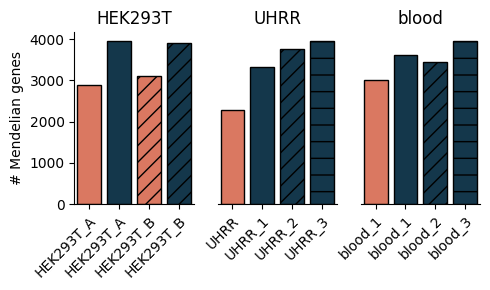

In [17]:

tissue_groups = gene_counts_10_sub2.groupby("tissue_flat")
colors_input = {"RNA002": "#ee6c4d", "RNA004": "#0b3954", "NGS": "#8b5cf6"}
hatches = [['','//', '', '//'],['', '', '//', '-'], ['', '', '//', '-'],['', '', '//', '//']]


bar_width = 0.6
spacing = 0
facet_widths = []

facet_data = []
for tissue, df in tissue_groups:
    n_bars = df['sample_type'].nunique()
    print(n_bars)
    width = max(1, n_bars * (bar_width + spacing))
    facet_data.append((tissue, df))
    facet_widths.append(width)

total_width = sum(facet_widths)
print(total_width)
normalized_widths = [w / total_width for w in facet_widths]

fig_height = 3
n_facets = len(facet_data)
fig, axes = plt.subplots(1, n_facets, figsize=(5, fig_height), 
                        gridspec_kw={'width_ratios': normalized_widths})

if n_facets == 1:
    axes = [axes]

for c, (ax, (tissue, df)) in enumerate(zip(axes, facet_data)):

    print(df.sort_values("ID")["sample_type"].unique())
    order_list = df.sort_values("ID")["sample_type"].unique()
    sns.barplot(
        data=df, y="# genes covered >= 10", x="sample_type", hue="chem_type",
        ax=ax, palette=colors_input,order  = order_list, edgecolor="black", width=0.8
    )
    if c >= 1:
        ax.tick_params(left=False, bottom=True, labelleft=False, labelbottom=True)
    ax.set_xticklabels([t.get_text().replace("RNA002_", "").replace("RNA004_", "") 
                        for t in ax.get_xticklabels()], rotation=45, ha = "right", rotation_mode='anchor')
    ax.grid(False)
    

    ax.set_title(tissue)
    ax.set_xlabel("")
    ax.set_ylabel("# Mendelian genes" if c == 0 else "")

    ax.legend([],[], frameon=False) 
    for i, bar in enumerate(ax.patches):
        if c < len(hatches) and i < len(hatches[c]):
            bar.set_hatch(hatches[c][i])
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    if c >= 1 and tissue != "Summed":
        ax.tick_params(left=False, bottom=True, labelleft=False, labelbottom=True)

        ax.spines["left"].set_visible(False)

fig.tight_layout()
fig.subplots_adjust(wspace=0.2, hspace=0)
fig.savefig("/raid/awiercze_analysis/RNA004_REVISION_NAR/PAPER_FIGURE_3A_NEW_MENDELIOM.svg", dpi = 300)
fig.savefig("/raid/awiercze_analysis/RNA004_REVISION_NAR/PAPER_FIGURE_3A_NEW_MENDELIOM.pdf", dpi = 300)
fig.savefig("/raid/awiercze_analysis/RNA004_REVISION_NAR/PAPER_FIGURE_3A_NEW_MENDELIOM.png", dpi = 300)


### Percentage of Mendeliome genes with coverage >= 10

/tmp/ipykernel_3028610/2971382906.py:57: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(
/tmp/ipykernel_3028610/2971382906.py:57: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(
/tmp/ipykernel_3028610/2971382906.py:57: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(


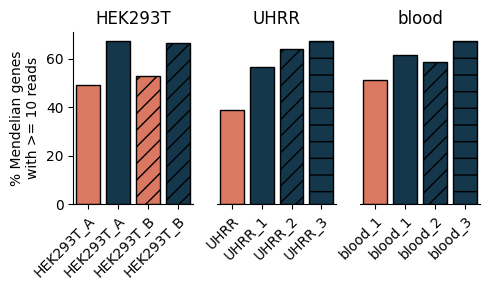

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# --- Setup ---
# Assume gene_counts_10 is a DataFrame and each row corresponds to a sample
# You must have a "total_genes" column or replace 20000 with actual total
TOTAL_GENES = len(counts_mendel)  # replace if dynamic

# Calculate percentage covered
gene_counts_10 = gene_counts_10_sub2.copy()
gene_counts_10["% genes covered >= 10"] = (gene_counts_10["# genes covered >= 10"] / TOTAL_GENES) * 100

# Group by tissue
tissue_groups = gene_counts_10.groupby("tissue_flat")
colors_input = {"RNA002": "#ee6c4d", "RNA004": "#0b3954", "NGS": "#8b5cf6"}
hatches = [['','//', '', '//'],['', '', '//', '-'], ['', '', '//', '-'],['', '', '//', '//']]

# Bar width settings
bar_width = 0.6
spacing = 0
facet_widths = []

facet_data = []
for tissue, df in tissue_groups:
    n_bars = df['sample_type'].nunique()
    width = max(1, n_bars * (bar_width + spacing))
    facet_data.append((tissue, df))
    facet_widths.append(width)

# Normalize subplot widths
total_width = sum(facet_widths)
normalized_widths = [w / total_width for w in facet_widths]

# Create subplots
fig_height = 3
n_facets = len(facet_data)
fig, axes = plt.subplots(1, n_facets, figsize=(5, fig_height), 
                         gridspec_kw={'width_ratios': normalized_widths})

# Handle single subplot
if n_facets == 1:
    axes = [axes]

# --- Plot each tissue facet ---
for c, (ax, (tissue, df)) in enumerate(zip(axes, facet_data)):
    order_list = df.sort_values("ID")["sample_type"].unique()
   
    sns.barplot(
        data=df, y="% genes covered >= 10", x="sample_type", hue="chem_type",
        ax=ax, palette=colors_input, order=order_list, edgecolor="black", width=0.8
    )

    if c >= 1:
        ax.tick_params(left=False, bottom=True, labelleft=False, labelbottom=True)

    ax.set_xticklabels(
        [t.get_text().replace("RNA002_", "").replace("RNA004_", "") 
         for t in ax.get_xticklabels()],
        rotation=45, ha="right", rotation_mode='anchor'
    )
    
    ax.grid(False)
    ax.set_title(tissue)
    ax.set_xlabel("")
    ax.set_ylabel("% Mendelian genes\nwith >= 10 reads" if c == 0 else "")
    ax.legend([], [], frameon=False)

    # Hatches
    for i, bar in enumerate(ax.patches):
        if c < len(hatches) and i < len(hatches[c]):
            bar.set_hatch(hatches[c][i])

    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    if c >= 1 and tissue != "Summed":
        ax.tick_params(left=False, bottom=True, labelleft=False, labelbottom=True)
        ax.spines["left"].set_visible(False)

fig.tight_layout()
fig.subplots_adjust(wspace=0.2, hspace=0)

fig.savefig("/raid/awiercze_analysis/RNA004_REVISION_NAR/PAPER_FIGURE_3A_NEW_MENDELIOM_perc.svg", dpi = 300)
fig.savefig("/raid/awiercze_analysis/RNA004_REVISION_NAR/PAPER_FIGURE_3A_NEW_MENDELIOM_perc.pdf", dpi = 300)
fig.savefig("/raid/awiercze_analysis/RNA004_REVISION_NAR/PAPER_FIGURE_3A_NEW_MENDELIOM_perc.png", dpi = 300)

plt.show()


In [ ]:
# SAVE NUMBER OF DISTINCT COVERED GENES
gene_counts_10.to_csv("~/NEW_RNA004_PLOTS/TABLES/PAPER_TABLE_Mendeliom_genes_covered.tsv", sep = "\t", index = False)

In [ ]:
# Save regions of mendeliom genes as bed file for subsequent analyses
# Extract mendeliome genes from sample-wise and technique-wise counts tables
counts_file="RNA002_RNA004.DORADO.0.7.2.GRCh38.featurecounts.tsv"
counts = pd.read_csv(counts_file, sep = "\t", header = 0, comment='#')
counts = counts.set_index("Geneid")
counts_regions = counts[['Chr', 'Start', 'End', 'Strand', 'Length']]
counts_regions.index = [i.split('.')[0] for i in counts_regions.index]
counts_regions["gene_id"] = counts_regions.index
counts_mendel_tmp = counts_regions[counts_regions["gene_id"].isin(mendeliom.ensembl_gene_id)]
counts_mendel_tmp['Chr'] = counts_mendel_tmp['Chr'].str.split(';').str[0]
counts_mendel_tmp['Start'] = counts_mendel_tmp['Start'].str.split(';').str[0]
counts_mendel_tmp['End'] = counts_mendel_tmp['End'].str.split(';').str[-1]
counts_mendel_tmp['Strand'] = counts_mendel_tmp['Strand'].str.split(';').str[0]
counts_mendel_tmp[["Chr", "Start", "End", "Strand", "gene_id"]].to_csv("mendeliome_gene_regions.bed", index = False, header = False, sep = "\t")

## SAVE COUNTS TABLE INCLUDING MENDELIOME ANNOTATION PER GENE

In [ ]:
counts_df_annot["transcript"] = [i.split('.')[0] for i in counts_df_annot["gene_id"]]
counts_df_annot["MENDELIOM"] = ["YES" if i in global_counts_mendel.index else "NO" for i in counts_df_annot["transcript"] ]
counts_df_annot.to_csv("~/NEW_RNA004_PLOTS/TABLES/PAPER_TABLES_RAW_COUNTS_ANNOT.tsv")
counts_df_annot.to_excel("~/NEW_RNA004_PLOTS/TABLES/PAPER_TABLES_RAW_COUNTS_ANNOT.xlsx")

# 3. DIFFERENTIAL EXPRESSION ANALYIS

In [30]:
metadata_tissue.to_csv("/home/awiercze/metadata.tsv", sep = "\t", index = False)
counts.to_csv("/home/awiercze/counts.tsv", sep = "\t", index = True)

In [ ]:
# R CODE LOCAL: 
""""
setwd("C:/Users/wie5a/Documents/RNA_MODIFCATIONS_DIAGNOSTICS")

# Load libraries
library(DESeq2)
library(ggplot2)
library(pheatmap)


# Load the count data
counts_data <- read.table("counts.tsv", sep = "\t", header = TRUE, row.names = 1)
# Load the sample information
metadata <- read.table("metadata.tsv", sep = "\t", header = TRUE, row.names = 1, comment.char = "")

metadata$tissue_flat = gsub("RNA00[2|4]_", "", metadata$tissue)
# Create a DESeqDataSet object
dds <- DESeqDataSetFromMatrix(countData = counts_data, colData = metadata, design = ~1)
# Pre-filtering: remove rows with low counts
dds <- dds[rowSums(counts(dds)) > 10, ]
# Run the DESeq2 pipeline
dds <- DESeq(dds)

# Plot PCA
rld <- rlog(dds)
pcaData <- plotPCA(rld, intgroup = c("chem_type", "tissue_flat"), returnData = TRUE)
percentVar <- round(100 * attr(pcaData, "percentVar"))  
p <- ggplot(pcaData, aes(x = PC1, y = PC2, color = chem_type, shape = tissue_flat)) +
  geom_point(size = 3) +
  xlab(paste0("PC1: ", percentVar[1], "% variance")) +
  ylab(paste0("PC2: ", percentVar[2], "% variance")) +
  theme_minimal()
# Save the PCA plot
ggsave("RNA004_PCA_plot.png", plot = p, width = 8, height = 6)

# Save the PCA data for further analysis
write.table(pcaData, file = "PCA_data.tsv", sep = "\t", quote = FALSE, row.names = TRUE, col.names = TRUE)
"""

In [ ]:
pca_data = pd.read_csv("/home/awiercze/PCA_data.tsv", sep = "\t", header = 0, index_col = 0)
percentVar = [80, 18] # FROM R SCRIPT

In [ ]:
colors_input = {"RNA002": "#ee6c4d", "RNA004": "#0b3954", "NGS" : "#8b5cf6"}
plt.figure(figsize=(5, 3.4))  # Optional: Increase figure size for better resolution
sns.scatterplot(
    data=pca_data,
    x="PC1",
    y="PC2",
    hue="chem_type",
    style="tissue_flat",
    palette=colors_input, markers={"HEK293T": "o", "blood": "s", "blood_IVT" : "D", "UHRR" : "X"},
    s=150  # Increase dot size
)

# Change axis labels
plt.xlabel("PC1 (" + str(percentVar[0]) + "% variance)", fontsize=14)
plt.ylabel("PC2 ("+ str(percentVar[1]) + "% variance)", fontsize=14)
plt.legend(bbox_to_anchor=(1.01, 0.99), loc='upper left', borderaxespad=0.)
# Optional: Improve layout
plt.tight_layout()

# Save as high-resolution image
plt.savefig("/raid/awiercze_analysis/RNA004_REVISION_NAR/pca_scatter_high_res.png", dpi=300)  # Save at 300 DPI
plt.savefig("/raid/awiercze_analysis/RNA004_REVISION_NAR/pca_scatter_high_res.pdf", dpi=300)  # Save at 300 DPI

plt.show()

# 4. GENE BODY COVERAGE 

In [31]:
metadata.loc[metadata["sample"].str.contains("_[2|3|B]"), :]

,sample,tissue,chem_type,ID,tissue_flat
1,RNA002_HEK293T_B,RNA002_HEK293T,RNA002,HEK293T_B,HEK293T
6,RNA004_HEK293T_B,RNA004_HEK293T,RNA004,HEK293T_B,HEK293T
10,RNA004_UHRR_2,RNA004_UHRR,RNA004,UHRR_2,UHRR
11,RNA004_UHRR_3,RNA004_UHRR,RNA004,UHRR_3,UHRR
12,RNA004_blood_2,RNA004_blood,RNA004,blood_2,blood
13,RNA004_blood_3,RNA004_blood,RNA004,blood_3,blood
14,RNA004_blood_IVT_3_R1,RNA004_blood_IVT,RNA004,blood_IVT_3_R1,blood_IVT
15,RNA004_blood_IVT_3_R2,RNA004_blood_IVT,RNA004,blood_IVT_3_R2,blood_IVT


In [32]:
geneBod = pd.read_csv("/raid/awiercze_analysis/GeneBodyCov_RNA002_RNA004_0.7.2.tsv", sep = "\t", header = 0)
metadata["Replicate"] = 1
metadata.loc[metadata["sample"].str.contains("_[2|B]"), "Replicate"] = 2
metadata.loc[metadata["sample"].str.contains("_3$"), "Replicate"] = 3

metadata.loc[metadata["sample"].str.contains("_3_R1"), "Replicate"] = 2
metadata.loc[metadata["sample"].str.contains("_3_R2"), "Replicate"] = 3

geneBod = geneBod.merge(metadata, left_on = "ID", right_on = "sample", how = "left")
geneBod["Chemistry"] = geneBod["Condition"].str.replace("_.*","", regex = True)
geneBod["tissue"] = geneBod["tissue"].str.replace("RNA00[2|4]_", "", regex = True)

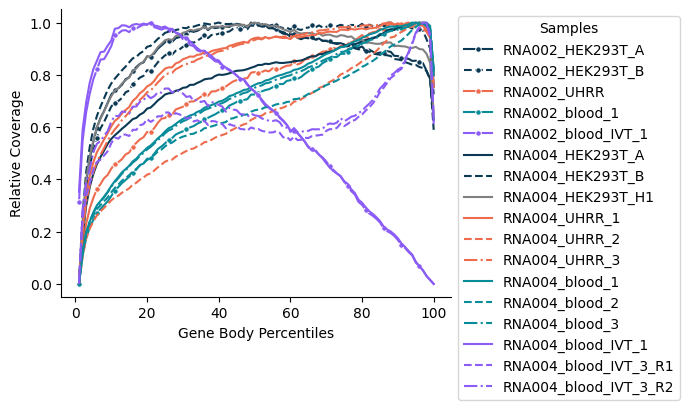

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(7, 4))

# Custom tissue color palette
tissue_palette = {
    "HEK293T": "#0b3954",
    "blood": "#098c9a",
    "UHRR": "#ee6c4d",
    "blood_IVT": "#8b5cf6"
}

# Optional: define marker shapes for each unique 'Shape'
linestyle_map = {
    1: "-",
    2: "--",
    3: "-.",
    4: ":"
}

shape_marker_map = {
    "RNA002": "o",
    "RNA004": ""
}

# Plot each ID_x group separately
for id_name, df_sub in geneBod.groupby("ID_x"):
    tissue = df_sub["tissue"].iloc[0]
    shape = df_sub["Replicate"].iloc[0]
    chemistry = df_sub["Chemistry"].iloc[0]

    linestyle = linestyle_map.get(shape, "-")  # default linestyle if missing
    color = tissue_palette.get(tissue, "gray")  # default color if tissue missing
    marker = shape_marker_map.get(chemistry, "")  # default marker if shape missing

    sns.lineplot(
        data=df_sub,
        x="Percentiles", y="PercVal",
        color=color,
        marker=marker,
        linestyle=linestyle,
        markersize=4,
        #markeredgecolor="black",
        #markeredgewidth=0.5,   
        ax=ax,
        label=id_name  # now works fine
    )
    for line in ax.lines:
        line.set_markevery(5)

# Format axes
ax.set(xlabel='Gene Body Percentiles', ylabel='Relative Coverage')
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.grid(False)

# Clean up legend
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1), title="Samples")
fig.tight_layout()

fig.savefig("/home/awiercze/NEW_RNA004_PLOTS/FIGURE2/PAPER_geneBodyCoverage_tissue.png", dpi = 300, transparent=True)
fig.savefig("/home/awiercze/NEW_RNA004_PLOTS/FIGURE2/PAPER_geneBodyCoverage_tissue.pdf", dpi = 300, transparent=True)